<a href="https://colab.research.google.com/github/LucianoRodriguez0764/ipadapter_faceid_colab/blob/main/Ipadapter_faceID_Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO-DO

Cosas que quedan por hacer:

- Cuando se deja de usar el x o y parameter, se queda seteado ese valor y no el del display, habría que ver como resetearlo pero parece difícil.
- Ver los distintos VAES y BASE MODELS, algun dropdown para que pueda elegir y updatear el pipeline rapido.

# Create folders

In [2]:
import os, shutil
from IPython.display import clear_output as clear_output_py

folder_path = "/content/images"
image_path = "images/embeds"
image_path_face = "images/face"

def empty_folders(embeds=True, face=True, log=True):
  global folder_path, image_path, image_path_face
  try:
    if embeds:
      # reseteo las variables faceid_embeds y faceid_embeds_avg.
      if "faceid_embeds" in globals():
        del globals()["faceid_embeds"]
      if "faceid_embeds_avg" in globals():
        del globals()["faceid_embeds_avg"]

      shutil.rmtree(folder_path+"/embeds")
      if log:
        print(f"Deleted folder: {folder_path}")
    if face:
      # reseteo las variables face_image_0 a face_image_n.
      i = 0
      while True:
          var_name = f"face_image_{i}"
          if var_name in globals():
              del globals()[var_name]
              i += 1
          else:
              break
      shutil.rmtree(folder_path+"/face")
      if log:
        print(f"Deleted folder: {folder_path}")
  except FileNotFoundError:
      if log:
        print(f"Folder not found: {folder_path}")
  except Exception as e:
      if log:
        print(f"An error occurred: {e}")

  os.makedirs(image_path, exist_ok=True)
  os.makedirs(image_path_face, exist_ok=True)

empty_folders()

clear_output_py()

# Installing dependencies and download the IP-Adapter-FaceID-Plus-v2 model

In [3]:
!pip install insightface # insightface-0.7.3
!pip install onnxruntime # onnxruntime-1.22.1
!pip install diffusers # diffusers 0.34.0
!pip install git+https://github.com/tencent-ailab/IP-Adapter.git # ip-adapter-0.1.0
!pip install einops # einops 0.8.1

clear_output_py()

In [4]:
!wget -O ip-adapter-faceid-plusv2_sd15.bin https://huggingface.co/h94/IP-Adapter-FaceID/resolve/main/ip-adapter-faceid-plusv2_sd15.bin

clear_output_py()

# Load FaceAnalysis model

In [5]:
import cv2
from insightface.app import FaceAnalysis
from insightface.utils import face_align
import torch
import glob
from PIL import Image as PILImage

app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

app_lower = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app_lower.prepare(ctx_id=0, det_size=(320, 320))

clear_output_py()

# Load the models to the pipeline

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from PIL import Image as PILImage

v2 = True
#base_model_path = "SG161222/Realistic_Vision_V6.0_B1_noVAE"
#base_model_path = "Lykon/dreamshaper-8"
#base_model_path = "Lykon/AbsoluteReality"
#base_model_path = "digiplay/AnalogMadness-realistic-model-v7"
base_model_path = "stablediffusionapi/epicrealism"

vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
ip_ckpt = "ip-adapter-faceid-plus_sd15.bin" if not v2 else "ip-adapter-faceid-plusv2_sd15.bin"
device = "cuda"

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

clear_output_py()

# Load the functions

In [73]:
from ip_adapter.ip_adapter_faceid import IPAdapterFaceIDPlus
import ipywidgets as widgets
import math
from IPython.display import Javascript

ip_model = IPAdapterFaceIDPlus(pipe, image_encoder_path, ip_ckpt, device)

clear_output_py()

image_output = widgets.Output()
text_output = widgets.Output()

images_array = []

def alert(message):
    js = f"""
    if (document.hidden) {{
        alert("{message}");
    }} else {{
        console.log("No se muestra alerta: pestaña activa");
    }}
    """
    display(Javascript(js))

def generate_x_list_seed(n, x_diff=True,forced_seed=-1):
    x_list_seed = []
    if x_diff:
      for i in range(n):
        if forced_seed == -1:
          x_list_seed.append(random.randint(1, 999999999))
        else:
          x_list_seed.append(forced_seed)
    else:
      if forced_seed == -1:
        x_list_seed = [random.randint(1, 999999999)]*n
      else:
        x_list_seed = [forced_seed]*n
    return x_list_seed

def generate_xy_seed_matrix(m, n, x_diff=True, y_diff=True, forced_seed=-1):
    xy_seed_matrix = []
    if y_diff:
      for i in range(n):
        xy_seed_matrix.append(generate_x_list_seed(m,x_diff,forced_seed))
    else:
      xy_seed_matrix = [generate_x_list_seed(m,x_diff,forced_seed)]*n
    return xy_seed_matrix

def generate_images():
  global ip_model, num_samples, num_inference_steps, guidance_scale, prompt, negative_prompt
  global face_image, faceid_embeds, seed, width, height, s_scale, shortcut, random_face_image, face_images_strings
  global x_plot_generation, y_plot_generation, x_plot_parameter, y_plot_parameter
  global x_plot_values, y_plot_values, x_different_seeds, y_different_seeds
  global image_output, text_output
  global images_array # Variable donde salvamos las imagenes por si a caso

  if num_inference_steps==0:
    num_inference_steps=1

  if seed == -1:
    seed = random.randint(1, 999999999)
    forced_seed = -1
  else:
    forced_seed = seed

  with text_output:
    print("n_samp:",num_samples, ":steps:",num_inference_steps, ":gui:",guidance_scale,":seed:", seed,":width:", width, ":height:",height,":s_scale:", s_scale,
            ":v2:",shortcut,":face_image:",face_image,":xplot:",x_plot_generation,":yplot:",y_plot_generation,":x_par:",x_plot_parameter,":y_par:",y_plot_parameter,":x_vals:",x_plot_values,":y_vals:",y_plot_values,":x_rnd:",x_different_seeds,":y_rnd:",y_different_seeds,":prompt:",prompt,":neg_prompt:", negative_prompt)

    rows = []

    if x_plot_generation:
      if y_plot_generation:
        xy_matrix_seed = generate_xy_seed_matrix(len(x_plot_values), len(y_plot_values), x_different_seeds, y_different_seeds, forced_seed)
      else:
        x_list_seed = generate_x_list_seed(len(x_plot_values), x_different_seeds)

    if x_plot_generation:
      num_samples=1
      if y_plot_generation:
        for h in range(len(y_plot_values)):
          images = []
          if y_plot_parameter in globals():
            if y_plot_parameter == "face_image" or y_plot_parameter == "faceid_embeds":
              if y_plot_parameter == "face_image":
                face_image_real = globals()[y_plot_values[h]]
              else:
                globals()[y_plot_parameter] = globals()[y_plot_values[h]]
              print("y parameter",y_plot_parameter,"set to:",y_plot_values[h])
            else:
              globals()[y_plot_parameter] = y_plot_values[h]
              print("y parameter",y_plot_parameter,"set to:",globals()[y_plot_parameter])
          for i in range(len(x_plot_values)):
            if x_plot_parameter == "face_image" or x_plot_parameter == "faceid_embeds":
              if x_plot_parameter == "face_image":
                face_image_real = globals()[x_plot_values[i]]
              else:
                globals()[x_plot_parameter] = globals()[x_plot_values[i]]
              print("x parameter",x_plot_parameter,"set to:",x_plot_values[i])
            else:
              globals()[x_plot_parameter] = x_plot_values[i]
              print("x parameter",x_plot_parameter,"set to:",globals()[x_plot_parameter])
            seed = xy_matrix_seed[h][i]
            print("Seed: ", seed)
            if random_face_image:
              face_image = random.choice(face_images_strings)
              print("face_image: ", face_image)
            if x_plot_parameter != "face_image" and y_plot_parameter != "face_image":
              face_image_real = globals()[face_image]
            generated_image = ip_model.generate(
                prompt=prompt+", "+extra_prompt, negative_prompt=negative_prompt, face_image=face_image_real, faceid_embeds=faceid_embeds, num_samples=num_samples, width=width, height=height, num_inference_steps=num_inference_steps, seed=seed,
                guidance_scale=guidance_scale, shortcut=shortcut, s_scale=s_scale,
            )[0]
            images_array.append(generated_image)
            images.append(generated_image)
          #endfor i
          rows.append(widgets.HBox([widgets.Image(value=img._repr_png_()) for img in images]))
        #endfor j
      else:
        images = []
        for i in range(len(x_plot_values)):
          if x_plot_parameter == "face_image" or x_plot_parameter == "faceid_embeds":
            if x_plot_parameter == "face_image":
              face_image_real = globals()[x_plot_values[i]]
            else:
              globals()[x_plot_parameter] = globals()[x_plot_values[i]]
            print("x parameter",x_plot_parameter,"set to:",x_plot_values[i])
          else:
            globals()[x_plot_parameter] = x_plot_values[i]
            print("x parameter",x_plot_parameter,"set to:",globals()[x_plot_parameter])
          seed = x_list_seed[i]
          print("Seed: ", seed)
          if random_face_image:
            face_image = random.choice(face_images_strings)
            print("face_image: ", face_image)
          if x_plot_parameter != "face_image":
            face_image_real = globals()[face_image]
          output_images = ip_model.generate(
          prompt=prompt+", "+extra_prompt, negative_prompt=negative_prompt, face_image=face_image_real, faceid_embeds=faceid_embeds, num_samples=num_samples, width=width, height=height, num_inference_steps=num_inference_steps, seed=seed,
          guidance_scale=guidance_scale, shortcut=shortcut, s_scale=s_scale)
          images.extend(output_images)
          images_array.extend(img for img in output_images)
        #endfor i
        rows.append(widgets.HBox([widgets.Image(value=img._repr_png_()) for img in images]))
    else:
      print("Seed: ", seed)
      if random_face_image:
        face_image = random.choice(face_images_strings)
        print("face_image: ", face_image)
      face_image_real = globals()[face_image]
      images = ip_model.generate(
          prompt=prompt+", "+extra_prompt, negative_prompt=negative_prompt, face_image=face_image_real, faceid_embeds=faceid_embeds, num_samples=num_samples, width=width, height=height, num_inference_steps=num_inference_steps, seed=seed,
          guidance_scale=guidance_scale, shortcut=shortcut, s_scale=s_scale
      )
      images_array.extend(img for img in images)
      rows.append(widgets.HBox([widgets.Image(value=img._repr_png_()) for img in images]))

  with image_output:
    for row in rows:
      display(row)

In [74]:
import ipywidgets as widgets
from IPython.display import display

slider_style = {'description_width': '200px'}
slider_layout = widgets.Layout(width='500px')

text_input = widgets.Text(placeholder="Add prompts separated by commas",style=slider_style, layout=slider_layout)
add_button = widgets.Button(description="Add tag")

prompt_array = []
neg_prompt_array = []
x_parameter_value_array = []
y_parameter_value_array = []

tags_box = widgets.HBox([])

def add_tag(b):
    text = text_input.value
    tags = text.split(",")

    for i in range(len(tags)):
        tags[i] = tags[i].strip()

    for tag in tags:
      if tag!="":
        tag_wi = widgets.HBox([
            widgets.HTML(value=f"<b>{tag}</b>"),
            widgets.Button(description="x", layout=widgets.Layout(width='30px'))
        ])
        prompt_array.append(tag)

        tags_box.children = list(tags_box.children) + [tag_wi]
        tag_wi.children[1].on_click(lambda b, tag_wi=tag_wi, tag=tag: remove_tag(tag_wi,tag))
    text_input.value = ""

def remove_tag(tag_wi,tag):
    global prompt_array
    tags_box.children = [child for child in tags_box.children if child != tag_wi]
    prompt_array = [x for x in prompt_array if x != tag]

add_button.on_click(add_tag)

######## NEGATIVE PROMPTS ###########

text_input_neg = widgets.Text(placeholder="Add negative prompts separated by commas", style=slider_style, layout=slider_layout)
add_button_neg = widgets.Button(description="Add tag")

tags_box_neg = widgets.HBox([])

def add_tag_neg(b):
    text = text_input_neg.value
    tags = text.split(",")

    for i in range(len(tags)):
        tags[i] = tags[i].strip()

    for tag in tags:
      if tag!="":
        tag_wi = widgets.HBox([
            widgets.HTML(value=f"<b>{tag}</b>"),
            widgets.Button(description="x", layout=widgets.Layout(margin="0px, 0px, 0px, 5px",width='30px'))
        ])
        neg_prompt_array.append(tag)

        tags_box_neg.children = list(tags_box_neg.children) + [tag_wi]
        tag_wi.children[1].on_click(lambda b, tag_wi=tag_wi, tag=tag: remove_tag_neg(tag_wi,tag))
    text_input_neg.value = ""


def remove_tag_neg(tag_wi,tag):
    global neg_prompt_array
    tags_box_neg.children = [child for child in tags_box_neg.children if child != tag_wi]
    neg_prompt_array = [x for x in neg_prompt_array if x != tag]

add_button_neg.on_click(add_tag_neg)


########### X PLOT Generation ###########

text_input_x = widgets.Text(placeholder="X Parameter values", disabled=True)
add_button_x = widgets.Button(description="Add value", disabled=True)

tags_box_x = widgets.HBox([])

def add_tag_x(b):
    text = text_input_x.value
    tags = text.split(",")

    for i in range(len(tags)):
        tags[i] = tags[i].strip()

    for tag in tags:
      if tag!="":
        tag_wi = widgets.HBox([
            widgets.HTML(value=f"<b>{tag}</b>"),
            widgets.Button(description="x", layout=widgets.Layout(width='30px'))
        ])
        x_parameter_value_array.append(tag)
        tags_box_x.children = list(tags_box_x.children) + [tag_wi]
        tag_wi.children[1].on_click(lambda b, tag_wi=tag_wi, tag=tag: remove_tag_x(tag_wi,tag))
    text_input_x.value = ""

def remove_all_tags_x():
    global x_parameter_value_array
    tags_box_x.children = []
    x_parameter_value_array = []

def remove_tag_x(tag_wi,tag):
    global x_parameter_value_array
    tags_box_x.children = [child for child in tags_box_x.children if child != tag_wi]

    if x_plot_parameter == "num_inference_steps":
      tag = int(tag)
    elif x_plot_parameter in ["guidance_scale", "s_scale"]:
      tag = float(tag)

    x_parameter_value_array = [x for x in x_parameter_value_array if x != tag]

add_button_x.on_click(add_tag_x)

########### Y PLOT Generation ###########

text_input_y = widgets.Text(placeholder="Y Parameter values", disabled=True)
add_button_y = widgets.Button(description="Add value", disabled=True)

tags_box_y = widgets.HBox([])

def add_tag_y(b):
    text = text_input_y.value
    tags = text.split(",")

    for i in range(len(tags)):
        tags[i] = tags[i].strip()

    for tag in tags:
      if tag!="":
        tag_wi = widgets.HBox([
            widgets.HTML(value=f"<b>{tag}</b>"),
            widgets.Button(description="x", layout=widgets.Layout(width='30px'))
        ])
        y_parameter_value_array.append(tag)
        tags_box_y.children = list(tags_box_y.children) + [tag_wi]
        tag_wi.children[1].on_click(lambda b, tag_wi=tag_wi, tag=tag: remove_tag_y(tag_wi,tag))
    text_input_y.value = ""

def remove_all_tags_y():
    global y_parameter_value_array
    tags_box_y.children = []
    y_parameter_value_array = []

def remove_tag_y(tag_wi,tag):
    global y_parameter_value_array
    tags_box_y.children = [child for child in tags_box_y.children if child != tag_wi]

    if y_plot_parameter == "num_inference_steps":
      tag = int(tag)
    elif y_plot_parameter in ["guidance_scale", "s_scale"]:
      tag = float(tag)

    y_parameter_value_array = [y for y in y_parameter_value_array if y != tag]

add_button_y.on_click(add_tag_y)

#Load Embeds and Faces

array([[[226, 201, 235],
        [226, 201, 235],
        [226, 201, 235],
        ...,
        [ 71,  98, 142],
        [ 43,  70, 114],
        [ 62,  88, 133]],

       [[226, 201, 235],
        [226, 201, 235],
        [226, 201, 235],
        ...,
        [ 52,  79, 123],
        [ 82, 109, 153],
        [ 50,  76, 122]],

       [[226, 201, 235],
        [226, 201, 235],
        [226, 201, 235],
        ...,
        [ 68,  95, 139],
        [ 82, 109, 153],
        [ 91, 120, 165]],

       ...,

       [[ 84, 115, 168],
        [ 90, 119, 169],
        [ 93, 117, 163],
        ...,
        [128, 158, 205],
        [126, 156, 203],
        [111, 141, 188]],

       [[ 81, 114, 166],
        [ 92, 116, 165],
        [139, 149, 194],
        ...,
        [127, 158, 204],
        [127, 157, 204],
        [118, 148, 197]],

       [[ 88, 121, 175],
        [111, 123, 171],
        [180, 174, 216],
        ...,
        [127, 158, 204],
        [123, 153, 200],
        [118, 148, 197]]], dtype=uint8)
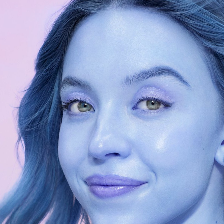

array([[[ 70,  55,  52],
        [ 70,  55,  52],
        [ 70,  55,  52],
        ...,
        [ 75,  60,  57],
        [ 75,  60,  57],
        [ 75,  60,  57]],

       [[ 70,  55,  52],
        [ 70,  55,  52],
        [ 70,  55,  52],
        ...,
        [ 75,  60,  57],
        [ 75,  60,  57],
        [ 75,  60,  57]],

       [[ 70,  55,  52],
        [ 70,  55,  52],
        [ 70,  55,  52],
        ...,
        [ 75,  60,  57],
        [ 75,  60,  57],
        [ 75,  60,  57]],

       ...,

       [[102, 125, 153],
        [ 91, 113, 141],
        [ 99, 121, 149],
        ...,
        [ 66,  83, 110],
        [ 92, 110, 137],
        [ 78,  98, 125]],

       [[ 99, 122, 150],
        [105, 127, 155],
        [119, 140, 168],
        ...,
        [ 60,  77, 104],
        [ 70,  87, 114],
        [ 87, 105, 132]],

       [[102, 124, 152],
        [110, 131, 158],
        [122, 143, 170],
        ...,
        [ 61,  78, 105],
        [ 61,  78, 105],
        [ 54,  71,  98]]], dtype=uint8)
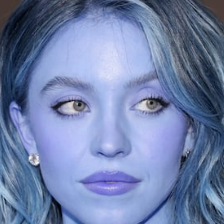

array([[[  2,   6,   7],
        [ 13,  17,  18],
        [  4,   9,  10],
        ...,
        [  8,  10,  10],
        [  9,  11,  11],
        [  9,  11,  11]],

       [[  3,   8,   9],
        [ 19,  24,  25],
        [ 16,  22,  23],
        ...,
        [  7,   9,   9],
        [  8,  10,  10],
        [  8,  10,  10]],

       [[ 52,  57,  58],
        [ 52,  58,  59],
        [ 56,  64,  64],
        ...,
        [  8,  10,  10],
        [  8,  10,  10],
        [  8,  10,  10]],

       ...,

       [[ 46,  62,  75],
        [ 70,  87, 102],
        [ 55,  75,  91],
        ...,
        [ 41,  72, 105],
        [ 40,  71, 104],
        [ 49,  80, 113]],

       [[ 46,  64,  77],
        [ 70,  88, 102],
        [ 54,  73,  87],
        ...,
        [ 38,  69, 102],
        [ 33,  64,  97],
        [ 51,  82, 115]],

       [[ 43,  65,  77],
        [ 76,  95, 108],
        [ 43,  62,  75],
        ...,
        [ 40,  72, 105],
        [ 30,  63,  96],
        [ 43,  76, 109]]], dtype=uint8)
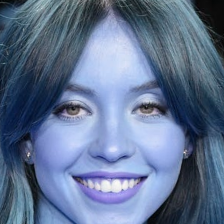

array([[[241, 217, 151],
        [241, 217, 151],
        [241, 217, 151],
        ...,
        [242, 218, 152],
        [242, 218, 152],
        [241, 217, 151]],

       [[241, 217, 151],
        [241, 217, 151],
        [241, 217, 151],
        ...,
        [242, 218, 152],
        [242, 218, 152],
        [241, 217, 151]],

       [[241, 217, 151],
        [241, 217, 151],
        [241, 217, 151],
        ...,
        [242, 218, 152],
        [242, 218, 152],
        [240, 216, 150]],

       ...,

       [[195, 211, 214],
        [185, 202, 211],
        [180, 198, 213],
        ...,
        [145, 184, 216],
        [155, 194, 226],
        [147, 188, 221]],

       [[194, 212, 213],
        [188, 205, 214],
        [181, 200, 214],
        ...,
        [153, 193, 226],
        [148, 191, 224],
        [141, 184, 217]],

       [[201, 213, 217],
        [193, 208, 217],
        [183, 203, 216],
        ...,
        [151, 192, 225],
        [139, 183, 216],
        [140, 186, 219]]], dtype=uint8)
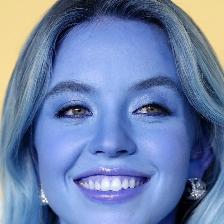

array([[[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       ...,

       [[104, 140, 188],
        [101, 137, 185],
        [103, 139, 186],
        ...,
        [138, 173, 223],
        [121, 156, 205],
        [127, 163, 211]],

       [[103, 139, 185],
        [119, 155, 201],
        [102, 138, 184],
        ...,
        [130, 165, 215],
        [122, 157, 207],
        [133, 168, 217]],

       [[ 94, 130, 175],
        [116, 152, 198],
        [110, 146, 192],
        ...,
        [121, 155, 207],
        [123, 158, 209],
        [131, 166, 215]]], dtype=uint8)
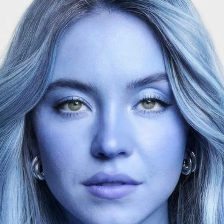

array([[[220, 212, 253],
        [220, 212, 253],
        [220, 212, 253],
        ...,
        [218, 210, 251],
        [218, 210, 251],
        [218, 210, 251]],

       [[220, 212, 253],
        [220, 212, 253],
        [220, 212, 253],
        ...,
        [218, 210, 251],
        [218, 210, 251],
        [218, 210, 251]],

       [[220, 212, 253],
        [220, 212, 253],
        [220, 212, 253],
        ...,
        [217, 209, 250],
        [217, 209, 250],
        [218, 210, 251]],

       ...,

       [[136, 177, 226],
        [137, 180, 229],
        [130, 173, 222],
        ...,
        [220, 213, 250],
        [220, 212, 252],
        [220, 212, 253]],

       [[137, 179, 226],
        [137, 178, 227],
        [132, 172, 224],
        ...,
        [220, 213, 250],
        [220, 212, 253],
        [220, 212, 253]],

       [[145, 186, 234],
        [141, 180, 228],
        [131, 172, 221],
        ...,
        [220, 213, 250],
        [220, 212, 253],
        [220, 212, 253]]], dtype=uint8)
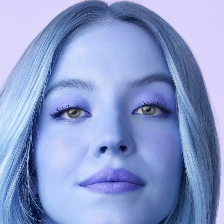

Collected face ID embeddings.


In [31]:
faceid_embeds_avg = None
faceid_embeds = None

def load_embeds(log=True):
  global faceid_embeds, faceid_embeds_avg
  imgs = glob.glob(os.path.join(image_path, '*.*'))
  imgs = sorted(imgs, key=lambda x: os.path.basename(x).lower())
  #imgs += glob.glob(os.path.join('images/face_2', '*.*'))

  # Collect all embeddings
  embeddings = []

  if len(imgs)==0:
    if log:
      print("You need to put face images on images/embeds for face-embedding and one image of face on images/face for face-id")

  for i in range(len(imgs)):
      #if log:
        #print(imgs[i])
      image = cv2.imread(imgs[i])
      faces = app.get(image)

      # Check if a face is detected
      if faces:
        face_image_aux = face_align.norm_crop(image, landmark=faces[0].kps, image_size=224)
        if log:
          display(face_image_aux)

        faceid_embed = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)
        embeddings.append(faceid_embed)
      else:
        if log:
          print("face not detected with 640x640, trying with 320x320")
        faces = app_lower.get(image)
        if faces:
          face_image_aux = face_align.norm_crop(image, landmark=faces[0].kps, image_size=224)
          if log:
            display(face_image_aux)

          faceid_embed = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)
          embeddings.append(faceid_embed)
        else:
          if log:
            print("face not detected.")

  # Calculate the average embedding for the face ID
  use_image_weights = False
  weights = []
  weights = [elem/sum(weights) for elem in weights] # normalization

  if embeddings:
      ### weights
      if use_image_weights:
        total = torch.zeros_like(embeddings[0])
        for i in range(len(embeddings)):
            if len(weights)==len(embeddings):
                total.add_(embeddings[i]*weights[i])
            else:
                total.add_(embeddings[i]*(1/len(embeddings)))
        faceid_embeds_avg = total / len(embeddings[i])
      ###  mean weights
      else:
        faceid_embeds = torch.mean(torch.stack(embeddings), dim=0)

      print("Collected face ID embeddings.")
  else:
      if log:
        print("No faces detected in the images provided.")

load_embeds()

face image detected with 640x640.
face_image_0


array([[[220, 212, 253],
        [220, 212, 253],
        [220, 212, 253],
        ...,
        [218, 210, 251],
        [218, 210, 251],
        [218, 210, 251]],

       [[220, 212, 253],
        [220, 212, 253],
        [220, 212, 253],
        ...,
        [218, 210, 251],
        [218, 210, 251],
        [218, 210, 251]],

       [[220, 212, 253],
        [220, 212, 253],
        [220, 212, 253],
        ...,
        [217, 209, 250],
        [217, 209, 250],
        [218, 210, 251]],

       ...,

       [[136, 177, 226],
        [137, 180, 229],
        [130, 173, 222],
        ...,
        [220, 213, 250],
        [220, 212, 252],
        [220, 212, 253]],

       [[137, 179, 226],
        [137, 178, 227],
        [132, 172, 224],
        ...,
        [220, 213, 250],
        [220, 212, 253],
        [220, 212, 253]],

       [[145, 186, 234],
        [141, 180, 228],
        [131, 172, 221],
        ...,
        [220, 213, 250],
        [220, 212, 253],
        [220, 212, 253]]], dtype=uint8)
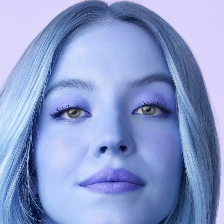

Collected face images.


In [32]:
def load_face(log=True):
  imgs_2 = glob.glob(os.path.join(image_path_face, '*.*'))
  imgs_2 = sorted(imgs_2, key=lambda x: os.path.basename(x).lower())

  imgs_2_array = []
  faces2_array = []

  image_start_index = 0
  image_basic_name = "face_image_"

  for i in imgs_2:
    img_aux = cv2.imread(i)
    imgs_2_array.append(img_aux)
    faces2_array.append(app.get(img_aux))

  for i in range(len(imgs_2)):
    if faces2_array[i]:
      if log:
        print("face image detected with 640x640.")
      face_image_aux_2 = face_align.norm_crop(imgs_2_array[i], landmark=faces2_array[i][0].kps, image_size=224)
      globals()[image_basic_name+str(image_start_index)] = face_image_aux_2
      image_start_index+=1
      if log:
        print(image_basic_name+str(image_start_index-1))
        display(face_image_aux_2)
    else:
      if log:
        print("face not detected with 640x640, trying with 320x320")
      faces2_array[i] = app_lower.get(imgs_2_array[i])
      if faces2_array[i]:
        if log:
          print("face image detected with 320x320.")
        face_image_aux_2 = face_align.norm_crop(imgs_2_array[i], landmark=faces2_array[i][0].kps, image_size=224)
        globals()[image_basic_name+str(image_start_index)] = face_image_aux_2
        image_start_index+=1
        if log:
          display(face_image_aux_2)
          print(image_basic_name+str(image_start_index-1))
      else:
        if log:
          print("face not detected.")
  print("Collected face images.")

load_face()

# Generate images with the IP-Adapter

In [75]:
from re import X
import random
import ipywidgets as widgets
from IPython.display import display, clear_output


#### DEFAULT SETTINGS ####

width=512
height=512
num_samples=1
num_inference_steps=30
guidance_scale = 2
s_scale = 1
x_plot_generation = False
y_plot_generation = False
x_plot_values = []
y_plot_values = []
tags_box = widgets.HBox([])
tags_box_neg = widgets.HBox([])
tags_box_x = widgets.HBox([])
tags_box_y = widgets.HBox([])
prompt_array = []
neg_prompt_array = []
x_parameter_value_array = []
y_parameter_value_array = []
x_plot_parameter = "num_inference_steps"
y_plot_parameter = "guidance_scale"
initial_prompt = ""
extra_prompt = ""
initial_negative_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, nfsw, extra legs, fused fingers, too many fingers, long neck"
initial_negative_prompt = ""
shortcut = True
x_different_seeds = False
y_different_seeds = False
random_face_image = False
face_id_embeds = faceid_embeds
face_image = "face_image_0"
seed = -1

checkbox_layout = widgets.Layout(width='auto', margin='0px 5px')

width_selector = widgets.Dropdown(
    options=[256, 288, 384, 512, 640, 768, 1024],
    value=512,
    description='Width:',
    style=slider_style,
    layout=slider_layout
)

height_selector = widgets.Dropdown(
    options=[256, 288, 384, 512, 640, 768, 1024],
    value=512,
    description='Height:',
    style=slider_style,
    layout=slider_layout
)


def on_size_change(change):
    global width, height
    #print(f"Selected Width: {width_selector.value}, Selected Height: {height_selector.value}")
    width = width_selector.value
    height = height_selector.value

width_selector.observe(on_size_change, names='value')
height_selector.observe(on_size_change, names='value')

num_inference_steps_slider = widgets.IntSlider(
    value=30,
    min=0,
    max=100,
    step=5,
    description='Num inference steps:',
    style=slider_style,
    layout=slider_layout
)

def on_num_inference_steps_scale_change(change):
    global num_inference_steps
    num_inference_steps = num_inference_steps_slider.value

num_inference_steps_slider.observe(on_num_inference_steps_scale_change, names='value')

num_samples_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=8,
    step=1,
    description='Num samples:',
    style=slider_style,
    layout=slider_layout
)

def on_num_samples_scale_change(change):
    global num_samples
    num_samples = num_samples_slider.value

num_samples_slider.observe(on_num_samples_scale_change, names='value')

guidance_scale_slider = widgets.FloatSlider(
    value=2,
    min=0.5,
    max=15,
    step=0.5,
    description='Guidance Scale:',
    style=slider_style,
    layout=slider_layout
)

def on_guidance_scale_change(change):
    global guidance_scale
    guidance_scale = guidance_scale_slider.value

guidance_scale_slider.observe(on_guidance_scale_change, names='value')

seed_slider = widgets.IntSlider(
    value=-1,
    min=-1,
    max=999999999,
    step=1,
    description='Seed:',
    style=slider_style,
    layout=slider_layout
)

def on_seed_change(change):
    global seed
    seed = seed_slider.value

seed_slider.observe(on_seed_change, names='value')

s_scale_slider = widgets.FloatSlider(
    value=1,
    min=0.0,
    max=3.0,
    step=0.1,
    description='s_scale:',
    style=slider_style,
    layout=slider_layout
)

def on_s_scale_change(change):
    global s_scale
    s_scale = s_scale_slider.value
    #print(f"Selected Guidance Scale: {guidance_scale_slider.value}")

s_scale_slider.observe(on_s_scale_change, names='value')

##################################################################################################################
# X Y PLOT BUTTONS
##################################################################################################################
x_plot_selector = widgets.Dropdown(
    options=['num_inference_steps', 'guidance_scale','s_scale','extra_prompt','face_image'],
    value='num_inference_steps',
    description='X Plot Parameters:',
    disabled=True,
    style=slider_style,
    layout=slider_layout
)

y_plot_selector = widgets.Dropdown(
    options=['num_inference_steps', 'guidance_scale','s_scale','extra_prompt','face_image'],
    value='guidance_scale',
    description='Y Plot Parameter:',
    disabled=True,
    style=slider_style,
    layout=slider_layout
)

x_randomseed_checkbox = widgets.Checkbox(
    value=False,
    description='Random X seed',
    disabled=False,
    indent=False
)
y_randomseed_checkbox = widgets.Checkbox(
    value=False,
    description='Random Y seed',
    disabled=False,
    indent=False
)

x_randomseed_checkbox.layout = checkbox_layout
y_randomseed_checkbox.layout = checkbox_layout

def y_plot_on_change(change):
    global y_plot_parameter
    y_plot_parameter = y_plot_selector.value

def x_plot_on_change(change):
    global x_plot_parameter
    x_plot_parameter = x_plot_selector.value

def x_randomseed_checkbox_on_change(change):
    global x_different_seeds
    x_different_seeds = x_randomseed_checkbox.value

def y_randomseed_checkbox_on_change(change):
    global y_different_seeds
    y_different_seeds = y_randomseed_checkbox.value

x_plot_checkbox = widgets.Checkbox(
    value=False,
    description='X Plot Generation',
    disabled=False,
    indent=False
)

y_plot_checkbox = widgets.Checkbox(
    value=False,
    description='Y Plot Generation',
    disabled=True,
    indent=False
)

x_plot_checkbox.layout = checkbox_layout
y_plot_checkbox.layout = checkbox_layout

#text_output.clear_output()
#image_output.clear_output()

x_plot_selector.observe(x_plot_on_change, names='value')
y_plot_selector.observe(y_plot_on_change, names='value')
x_randomseed_checkbox.observe(x_randomseed_checkbox_on_change, names='value')
y_randomseed_checkbox.observe(y_randomseed_checkbox_on_change, names='value')

def x_plot_checkbox_change(change):
    global x_plot_generation
    x_plot_generation = x_plot_checkbox.value

    x_plot_selector.disabled = not x_plot_checkbox.value
    text_input_x.disabled = not x_plot_checkbox.value
    add_button_x.disabled = not x_plot_checkbox.value
    tags_box_x.disabled = not x_plot_checkbox.value
    y_plot_checkbox.disabled = not x_plot_checkbox.value

    if not x_plot_checkbox.value:
      remove_all_tags_x()

    if x_plot_selector.value == 'extra_prompt':
      global extra_prompt
      extra_prompt = ''

def y_plot_checkbox_change(change):
    global y_plot_generation
    y_plot_generation = y_plot_checkbox.value

    y_plot_selector.disabled = not y_plot_checkbox.value
    text_input_y.disabled = not y_plot_checkbox.value
    add_button_y.disabled = not y_plot_checkbox.value
    tags_box_y.disabled = not y_plot_checkbox.value

    if not y_plot_checkbox.value:
      remove_all_tags_y()

    if y_plot_selector.value == 'extra_prompt':
      global extra_prompt
      extra_prompt = ''

x_plot_checkbox.observe(x_plot_checkbox_change, names='value')
y_plot_checkbox.observe(y_plot_checkbox_change, names='value')

x_y_plot_checkbox_container = widgets.HBox(
    [x_plot_checkbox, y_plot_checkbox],
    layout=widgets.Layout(justify_content='center', width='600px', margin="0px")
)
random_checkbox_container = widgets.HBox(
    [x_randomseed_checkbox, y_randomseed_checkbox],
    layout=widgets.Layout(justify_content='center', width='600px', margin="0px")
)
##################################################################################################################
# GENERATE IMAGES BUTTON
##################################################################################################################
generate_button = widgets.Button(description="Generate images")
generate_button.layout = widgets.Layout(width='300px', height="40px")

def on_generate_click(b):
    global ip_model, num_samples, num_inference_steps, guidance_scale, prompt, negative_prompt, face_image, faceid_embeds, seed, width, height, s_scale, shortcut,x_plot_generation,y_plot_generation,x_plot_parameter,y_plot_parameter,x_plot_values,y_plot_values,xy_different_seeds,prompt_array,neg_prompt_array,x_parameter_value_array,y_parameter_value_array

    prompt = initial_prompt
    negative_prompt = initial_negative_prompt

    if len(neg_prompt_array) > 0:
      negative_prompt += ", "+", ".join(neg_prompt_array)

    if len(prompt_array) > 0:
      prompt += ", "+", ".join(prompt_array)

    if x_plot_parameter in ["guidance_scale", "s_scale"] and x_plot_generation:
      x_plot_values = [float(value) for value in x_parameter_value_array]
      x_parameter_value_array = [float(value) for value in x_parameter_value_array]
    elif x_plot_parameter=="num_inference_steps":
      x_plot_values = [int(value) for value in x_parameter_value_array]
      x_parameter_value_array = [int(value) for value in x_parameter_value_array]
    else:
      x_plot_values = x_parameter_value_array

    if y_plot_parameter in ["guidance_scale", "s_scale"] and y_plot_generation:
      y_plot_values = [float(value) for value in y_parameter_value_array]
      y_parameter_value_array = [float(value) for value in y_parameter_value_array]
    elif y_plot_parameter=="num_inference_steps":
      y_plot_values = [int(value) for value in y_parameter_value_array]
      y_parameter_value_array = [int(value) for value in y_parameter_value_array]
    else:
      y_plot_values = y_parameter_value_array

    text_output.clear_output()
    image_output.clear_output()
    generate_images()
    alert("Images generated")

    old_seed = seed
    if old_seed != seed_slider.value:
      seed = -1


generate_button.on_click(on_generate_click)
generate_button_container = widgets.HBox([generate_button])
generate_button_container.layout = widgets.Layout(width='500px',justify_content="center",display="flex")

##################################################################################################################
# CLEAN BUTTONS
##################################################################################################################
clean_button = widgets.Button(description="Clean embed images")
clean_button.layout = widgets.Layout(width='200px', height="30px")

def on_clean_click(b):
  empty_folders(embeds=True, face=False, log=False)

clean_button_2 = widgets.Button(description="Clean face images")
clean_button_2.layout = widgets.Layout(width='200px', height="30px")

def on_clean_click_2(b):
  empty_folders(embeds=False, face=True, log=False)

clean_outputs_button = widgets.Button(description="Clean screen")
clean_outputs_button.layout = widgets.Layout(width='200px', height="30px")

def clean_output_on_click(b):
  image_output.clear_output()
  text_output.clear_output()

clean_button.on_click(on_clean_click)
clean_button_2.on_click(on_clean_click_2)
clean_outputs_button.on_click(clean_output_on_click)
clean_button_container = widgets.HBox([clean_button, clean_button_2, clean_outputs_button])
clean_button_container.layout = widgets.Layout(width='500px',justify_content="center",display="flex")

##################################################################################################################
# LOAD IMAGE BUTTONS
##################################################################################################################
load_embeds_button = widgets.Button(description="Load embed images")
load_embeds_button.layout = widgets.Layout(width='200px', height="30px")

def on_load_click(b):
  load_embeds(log=False)

load_faces_button = widgets.Button(description="Load face images")
load_faces_button.layout = widgets.Layout(width='200px', height="30px")

def on_load_click_2(b):
  load_face(log=False)

load_embeds_button.on_click(on_load_click)
load_faces_button.on_click(on_load_click_2)
load_images_container = widgets.HBox([load_embeds_button, load_faces_button])
load_images_container.layout = widgets.Layout(width='500px',justify_content="center",display="flex")

##################################################################################################################
# FACE IMAGE DROPDOWN AND CHECKBOX
##################################################################################################################
face_images_strings = []
i = 0
while True:
    var_name = f"face_image_{i}"
    if var_name in globals():
        face_images_strings.append(var_name)
        i += 1
    else:
        break

if i==0:
  face_images_strings = ["face_image_0"]

face_image_selector = widgets.Dropdown(
    options=face_images_strings,
    value='face_image_0',
    description='Face image:',
    disabled=False,
    style=slider_style,
    layout=slider_layout
)

# note: face_image_real is the image itself, face_image is the string that determines the image
def face_image_selector_on_change(change):
    global face_image
    face_image = face_image_selector.value

face_image_selector.observe(face_image_selector_on_change, names='value')

random_faceimage_checkbox = widgets.Checkbox(
    value=False,
    description='Random face_image',
    disabled=False,
    indent=True,
    style=slider_style,
    layout=slider_layout
)

def random_faceimage_checkbox_on_change(change):
    global random_face_image
    random_face_image = random_faceimage_checkbox.value

random_faceimage_checkbox.observe(random_faceimage_checkbox_on_change, names='value')

##################################################################################################################

add_button_container = widgets.HBox([add_button])
add_button_container.layout = widgets.Layout(width='500px',justify_content="center", display="flex")

add_button_neg_container = widgets.HBox([add_button_neg])
add_button_neg_container.layout = widgets.Layout(width='500px',justify_content="center", display="flex")

In [ ]:
display(clean_button_container)
display(load_images_container)

#display(load_embeds_button_container, load_faces_button_container)

display(text_input, add_button_container, tags_box)
display(text_input_neg, add_button_neg_container, tags_box_neg)

display(width_selector, height_selector, face_image_selector, random_faceimage_checkbox, num_samples_slider, num_inference_steps_slider, guidance_scale_slider,
        seed_slider, s_scale_slider)
display(x_y_plot_checkbox_container)
display(x_plot_selector,y_plot_selector)
display(random_checkbox_container)

add_button_x_container = widgets.HBox([add_button_x])
add_button_x_container.layout = widgets.Layout(width='500px',justify_content="center", display="flex")
add_button_y_container = widgets.HBox([add_button_y])
add_button_y_container.layout = widgets.Layout(width='500px',justify_content="center", display="flex")
text_input_x_container = widgets.HBox([text_input_x])
text_input_x_container.layout = widgets.Layout(width='500px',justify_content="center", display="flex")
text_input_y_container = widgets.HBox([text_input_y])
text_input_y_container.layout = widgets.Layout(width='500px',justify_content="center", display="flex")

display(text_input_x_container, add_button_x_container, tags_box_x)
display(text_input_y_container, add_button_y_container, tags_box_y)

display(generate_button_container)

display(text_output, image_output)